<a href="https://colab.research.google.com/github/tarumi283/tarumi/blob/main/%E6%9C%80%E6%96%B0%E7%89%88_gbm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================
# Cell 0) 依存関係 & import
# =========================================
# !pip -q install scanpy anndata h5py scipy scikit-learn requests

from pathlib import Path
import tarfile, shutil
import numpy as np
import pandas as pd
import requests
import scanpy as sc
import scipy.sparse as sp

sc.settings.verbosity = 2


In [ ]:
# =========================================
# Cell 1) 作業ディレクトリ & ダウンロード
# =========================================
BASE = Path("GSE162931_work")
BASE.mkdir(exist_ok=True)

RAW_TAR = BASE / "GSE162931_RAW.tar"
TMP = BASE / "tmp"
TMP.mkdir(exist_ok=True)

def download(url, outpath, chunk=1024*1024):
    outpath.parent.mkdir(parents=True, exist_ok=True)
    if outpath.exists() and outpath.stat().st_size > 0:
        print("[SKIP] already downloaded:", outpath, f"{outpath.stat().st_size/1e6:.1f} MB")
        return
    print("[DL]", url)
    with requests.get(url, stream=True, timeout=60) as r:
        r.raise_for_status()
        with open(outpath, "wb") as f:
            for c in r.iter_content(chunk_size=chunk):
                if c:
                    f.write(c)
    print("[OK] saved:", outpath, f"{outpath.stat().st_size/1e6:.1f} MB")

url_raw = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE162nnn/GSE162931/suppl/GSE162931_RAW.tar"
download(url_raw, RAW_TAR)


[SKIP] already downloaded: GSE162931_work/GSE162931_RAW.tar 689.2 MB


In [ ]:
# =========================================
# Cell 2) サンプルメタ情報（固定）
# =========================================
sample_info = {
    "GSM4967236": {"line": "GBM131", "condition": "naive", "timepoint": "0d"},
    "GSM4967237": {"line": "GBM131", "condition": "RT",    "timepoint": "2d"},
    "GSM4967239": {"line": "GBM131", "condition": "RT",    "timepoint": "5d"},
    "GSM4967241": {"line": "GBM131", "condition": "RT",    "timepoint": "3w"},
    "GSM4967242": {"line": "GBM022", "condition": "naive", "timepoint": "0d"},
    "GSM4967244": {"line": "GBM022", "condition": "RT",    "timepoint": "2d"},
    "GSM4967246": {"line": "GBM827", "condition": "naive", "timepoint": "0d"},
    "GSM4967248": {"line": "GBM827", "condition": "RT",    "timepoint": "2d"},
}

def mk_group_tp(r):
    return "naive_0d" if r["condition"]=="naive" else f"RT_{r['timepoint']}"

categories = ["naive_0d","RT_2d","RT_5d","RT_3w"]


In [ ]:
# =========================================
# Cell 2) サンプルメタ情報（固定）
# =========================================
sample_info = {
    "GSM4967236": {"line": "GBM131", "condition": "naive", "timepoint": "0d"},
    "GSM4967237": {"line": "GBM131", "condition": "RT",    "timepoint": "2d"},
    "GSM4967239": {"line": "GBM131", "condition": "RT",    "timepoint": "5d"},
    "GSM4967241": {"line": "GBM131", "condition": "RT",    "timepoint": "3w"},
    "GSM4967242": {"line": "GBM022", "condition": "naive", "timepoint": "0d"},
    "GSM4967244": {"line": "GBM022", "condition": "RT",    "timepoint": "2d"},
    "GSM4967246": {"line": "GBM827", "condition": "naive", "timepoint": "0d"},
    "GSM4967248": {"line": "GBM827", "condition": "RT",    "timepoint": "2d"},
}

def mk_group_tp(r):
    return "naive_0d" if r["condition"]=="naive" else f"RT_{r['timepoint']}"

categories = ["naive_0d","RT_2d","RT_5d","RT_3w"]


In [ ]:
# =========================================
# Cell 3) RAW.tarの中身を確認（tar.gz を列挙）
# =========================================
with tarfile.open(RAW_TAR, "r") as tf:
    members = [m for m in tf.getmembers() if m.name.endswith(".tar.gz")]

print("n(tar.gz) in RAW.tar =", len(members))
print("example:", [m.name for m in members[:5]])

# 対象GSMだけ抽出
target_members = []
for m in members:
    base = Path(m.name).name
    gsm = base.split("_")[0]
    if gsm in sample_info:
        target_members.append(m)

print("target tar.gz =", len(target_members))
print([Path(m.name).name for m in target_members])


n(tar.gz) in RAW.tar = 8
example: ['GSM4967236_Lee1_filtered_feature_bc_matrix.tar.gz', 'GSM4967237_Lee2_filtered_feature_bc_matrix.tar.gz', 'GSM4967239_Lee3_filtered_feature_bc_matrix.tar.gz', 'GSM4967241_Lee4_filtered_feature_bc_matrix.tar.gz', 'GSM4967242_Lee5_filtered_feature_bc_matrix.tar.gz']
target tar.gz = 8
['GSM4967236_Lee1_filtered_feature_bc_matrix.tar.gz', 'GSM4967237_Lee2_filtered_feature_bc_matrix.tar.gz', 'GSM4967239_Lee3_filtered_feature_bc_matrix.tar.gz', 'GSM4967241_Lee4_filtered_feature_bc_matrix.tar.gz', 'GSM4967242_Lee5_filtered_feature_bc_matrix.tar.gz', 'GSM4967244_Lee6_filtered_feature_bc_matrix.tar.gz', 'GSM4967246_Lee7_filtered_feature_bc_matrix.tar.gz', 'GSM4967248_Lee8_filtered_feature_bc_matrix.tar.gz']


In [ ]:
# =========================================
# Cell 4) 10xフォルダ探索関数
# =========================================
def find_10x_dir(root: Path) -> Path | None:
    def exists_any(d, names):
        return any((d / n).exists() for n in names)

    for d in [root] + [p for p in root.rglob("*") if p.is_dir()]:
        if (exists_any(d, ["matrix.mtx", "matrix.mtx.gz"]) and
            exists_any(d, ["barcodes.tsv", "barcodes.tsv.gz"]) and
            exists_any(d, ["features.tsv", "features.tsv.gz", "genes.tsv", "genes.tsv.gz"])):
            return d
    return None


In [ ]:
# =========================================
# Cell 5) 1サンプルずつ抽出→read_10x→軽量保存（ここが重要）
#  - ここでは「各サンプルを個別に .h5ad 保存」して、後で結合する
#  - メモリ節約のため、中間ファイルは都度削除
# =========================================
SAMPLE_DIR = BASE / "samples_h5ad"
SAMPLE_DIR.mkdir(exist_ok=True)

def quick_stat(ad, name=""):
    X = ad.X
    nnz = X.nnz if sp.issparse(X) else np.count_nonzero(X)
    print(f"[{name}] shape={ad.shape} nnz={nnz} Xtype={type(X)} dtype={X.dtype}")

with tarfile.open(RAW_TAR, "r") as tf:
    for m in target_members:
        base = Path(m.name).name
        gsm = base.split("_")[0]
        out_h5ad = SAMPLE_DIR / f"{gsm}.h5ad"
        if out_h5ad.exists():
            print("[SKIP] exists:", out_h5ad.name)
            continue

        tgz_path = TMP / base
        outdir = TMP / base.replace(".tar.gz", "")

        # A) tar.gzを一時保存
        print("\n[EXTRACT tgz]", base)
        if tgz_path.exists(): tgz_path.unlink()
        with tf.extractfile(m) as f_in, open(tgz_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out, length=1024*1024)

        # B) 展開
        if outdir.exists(): shutil.rmtree(outdir)
        outdir.mkdir(parents=True, exist_ok=True)

        print("[UNTAR tgz]", outdir)
        with tarfile.open(tgz_path, "r:gz") as tfgz:
            tfgz.extractall(outdir)

        # C) 10x読込
        tenx = find_10x_dir(outdir)
        if tenx is None:
            raise RuntimeError(f"10x directory not found in {outdir}")

        print("[READ 10x]", gsm, tenx)
        ad = sc.read_10x_mtx(tenx, var_names="gene_symbols", cache=False)
        ad.var_names_make_unique()

        # D) メタデータ
        ad.obs["GSM"] = gsm
        ad.obs["line"] = sample_info[gsm]["line"]
        ad.obs["condition"] = sample_info[gsm]["condition"]
        ad.obs["timepoint"] = sample_info[gsm]["timepoint"]
        ad.obs["group_tp"] = pd.Categorical(
            ad.obs.apply(lambda r: mk_group_tp(r), axis=1),
            categories=categories,
            ordered=True
        )

        # E) dtypeをfloat32へ（これ超重要）
        if sp.issparse(ad.X):
            ad.X = ad.X.astype(np.float32)
        else:
            ad.X = ad.X.astype(np.float32, copy=False)

        quick_stat(ad, gsm)

        # F) 保存
        ad.write(out_h5ad)
        print("[SAVE]", out_h5ad)

        # G) 中間削除
        tgz_path.unlink(missing_ok=True)
        shutil.rmtree(outdir, ignore_errors=True)

print("\nDone. Saved h5ad in:", SAMPLE_DIR)



[EXTRACT tgz] GSM4967236_Lee1_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967236_Lee1_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967236 GSE162931_work/tmp/GSM4967236_Lee1_filtered_feature_bc_matrix
[GSM4967236] shape=(12022, 33694) nnz=39650845 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967236.h5ad

[EXTRACT tgz] GSM4967237_Lee2_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967237_Lee2_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967237 GSE162931_work/tmp/GSM4967237_Lee2_filtered_feature_bc_matrix
[GSM4967237] shape=(7931, 33694) nnz=18728717 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967237.h5ad

[EXTRACT tgz] GSM4967239_Lee3_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967239_Lee3_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967239 GSE162931_work/tmp/GSM4967239_Lee3_filtered_feature_bc_matrix
[GSM4967239] shape=(11311, 33694) nnz=35692782 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967239.h5ad

[EXTRACT tgz] GSM4967241_Lee4_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967241_Lee4_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967241 GSE162931_work/tmp/GSM4967241_Lee4_filtered_feature_bc_matrix
[GSM4967241] shape=(21924, 33694) nnz=38504221 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967241.h5ad

[EXTRACT tgz] GSM4967242_Lee5_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967242_Lee5_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967242 GSE162931_work/tmp/GSM4967242_Lee5_filtered_feature_bc_matrix
[GSM4967242] shape=(9002, 33694) nnz=19511243 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967242.h5ad

[EXTRACT tgz] GSM4967244_Lee6_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967244_Lee6_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967244 GSE162931_work/tmp/GSM4967244_Lee6_filtered_feature_bc_matrix
[GSM4967244] shape=(11288, 33694) nnz=32777298 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967244.h5ad

[EXTRACT tgz] GSM4967246_Lee7_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967246_Lee7_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967246 GSE162931_work/tmp/GSM4967246_Lee7_filtered_feature_bc_matrix
[GSM4967246] shape=(12144, 33694) nnz=24213602 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967246.h5ad

[EXTRACT tgz] GSM4967248_Lee8_filtered_feature_bc_matrix.tar.gz
[UNTAR tgz] GSE162931_work/tmp/GSM4967248_Lee8_filtered_feature_bc_matrix


/tmp/ipython-input-3259175124.py:38: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfgz.extractall(outdir)


[READ 10x] GSM4967248 GSE162931_work/tmp/GSM4967248_Lee8_filtered_feature_bc_matrix
[GSM4967248] shape=(5200, 33694) nnz=14043539 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[SAVE] GSE162931_work/samples_h5ad/GSM4967248.h5ad

Done. Saved h5ad in: GSE162931_work/samples_h5ad


In [ ]:
# =========================================
# Cell 6) 8サンプルを読み込み（結合はまだしない）
# =========================================
h5ads = sorted(SAMPLE_DIR.glob("GSM*.h5ad"))
print("n(h5ad) =", len(h5ads), [p.name for p in h5ads])

ad_list = []
for p in h5ads:
    ad = sc.read_h5ad(p)
    ad_list.append(ad)
    quick_stat(ad, p.stem)


n(h5ad) = 8 ['GSM4967236.h5ad', 'GSM4967237.h5ad', 'GSM4967239.h5ad', 'GSM4967241.h5ad', 'GSM4967242.h5ad', 'GSM4967244.h5ad', 'GSM4967246.h5ad', 'GSM4967248.h5ad']
[GSM4967236] shape=(12022, 33694) nnz=39650845 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967237] shape=(7931, 33694) nnz=18728717 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967239] shape=(11311, 33694) nnz=35692782 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967241] shape=(21924, 33694) nnz=38504221 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967242] shape=(9002, 33694) nnz=19511243 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967244] shape=(11288, 33694) nnz=32777298 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967246] shape=(12144, 33694) nnz=24213602 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtype=float32
[GSM4967248] shape=(5200, 33694) nnz=14043539 Xtype=<class 'scipy.sparse._csc.csc_matrix'> dtyp

In [ ]:
import scanpy as sc
import scipy.sparse as sp
import numpy as np
from pathlib import Path

# ---- h5ad を読む（Cell 6 を兼ねる）----
SAMPLE_DIR = Path("GSE162931_work/samples_h5ad")
h5ads = sorted(SAMPLE_DIR.glob("GSM*.h5ad"))

print("found h5ad files:", [p.name for p in h5ads])

ad_list = []
for p in h5ads:
    ad = sc.read_h5ad(p)
    ad_list.append(ad)

# ---- 診断 ----
def quick_stat(ad, name=""):
    X = ad.X
    nnz = X.nnz if sp.issparse(X) else np.count_nonzero(X)
    print(f"[{name}] cells={ad.n_obs:,} genes={ad.n_vars:,} nnz={nnz:,} "
          f"X={type(X).__name__} dtype={X.dtype}")

print("\n---- per-sample stats ----")
for i, ad in enumerate(ad_list):
    gsm = ad.obs["GSM"].iloc[0] if "GSM" in ad.obs else f"sample{i}"
    quick_stat(ad, gsm)




found h5ad files: ['GSM4967236.h5ad', 'GSM4967237.h5ad', 'GSM4967239.h5ad', 'GSM4967241.h5ad', 'GSM4967242.h5ad', 'GSM4967244.h5ad', 'GSM4967246.h5ad', 'GSM4967248.h5ad']

---- per-sample stats ----
[GSM4967236] cells=12,022 genes=33,694 nnz=39,650,845 X=csc_matrix dtype=float32
[GSM4967237] cells=7,931 genes=33,694 nnz=18,728,717 X=csc_matrix dtype=float32
[GSM4967239] cells=11,311 genes=33,694 nnz=35,692,782 X=csc_matrix dtype=float32
[GSM4967241] cells=21,924 genes=33,694 nnz=38,504,221 X=csc_matrix dtype=float32
[GSM4967242] cells=9,002 genes=33,694 nnz=19,511,243 X=csc_matrix dtype=float32
[GSM4967244] cells=11,288 genes=33,694 nnz=32,777,298 X=csc_matrix dtype=float32
[GSM4967246] cells=12,144 genes=33,694 nnz=24,213,602 X=csc_matrix dtype=float32
[GSM4967248] cells=5,200 genes=33,694 nnz=14,043,539 X=csc_matrix dtype=float32


In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd

def downsample_cells(ad, n=5000, seed=0):
    if ad.n_obs <= n:
        return ad
    rng = np.random.default_rng(seed)
    idx = rng.choice(ad.n_obs, size=n, replace=False)
    return ad[idx].copy()

def concat_pairwise_safe(ad_list, join="inner", max_cells_per_sample=None):
    if max_cells_per_sample is not None:
        ad_list = [
            downsample_cells(ad, n=max_cells_per_sample, seed=i)
            for i, ad in enumerate(ad_list)
        ]

    out = ad_list[0]
    for i in range(1, len(ad_list)):
        out = sc.concat([out, ad_list[i]], join=join)
        print(f"[pairwise] after {i+1} samples: {out.shape}")
    return out

# まずは間引きなしで試す
try:
    adata = concat_pairwise_safe(ad_list, join="inner", max_cells_per_sample=None)
except Exception as e:
    print("\n[concat failed] retry with 5000 cells/sample")
    adata = concat_pairwise_safe(ad_list, join="inner", max_cells_per_sample=5000)

print("\n[FINAL adata]")
print(adata)
print(pd.crosstab(adata.obs["condition"], adata.obs["timepoint"]))


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[pairwise] after 2 samples: (19953, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[pairwise] after 3 samples: (31264, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[pairwise] after 4 samples: (53188, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[pairwise] after 5 samples: (62190, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[pairwise] after 6 samples: (73478, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


[pairwise] after 7 samples: (85622, 33694)
[pairwise] after 8 samples: (90822, 33694)

[FINAL adata]
AnnData object with n_obs × n_vars = 90822 × 33694
    obs: 'GSM', 'line', 'condition', 'timepoint', 'group_tp'
timepoint     0d     2d     3w     5d
condition                            
RT             0  24419  21924  11311
naive      33168      0      0      0


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
import numpy as np
import scanpy as sc
import scipy.sparse as sp

# 念のため float32（メモリ半減）
if sp.issparse(adata.X):
    adata.X = adata.X.astype(np.float32)
else:
    adata.X = adata.X.astype(np.float32, copy=False)

# MT判定 & QC
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

print("Before QC:", adata.shape)
adata = adata[adata.obs["n_genes_by_counts"] >= 200].copy()
adata = adata[adata.obs["pct_counts_mt"] <= 25].copy()
print("After  QC:", adata.shape)


Before QC: (90822, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


After  QC: (86295, 33694)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


After HVG: (86295, 2000)


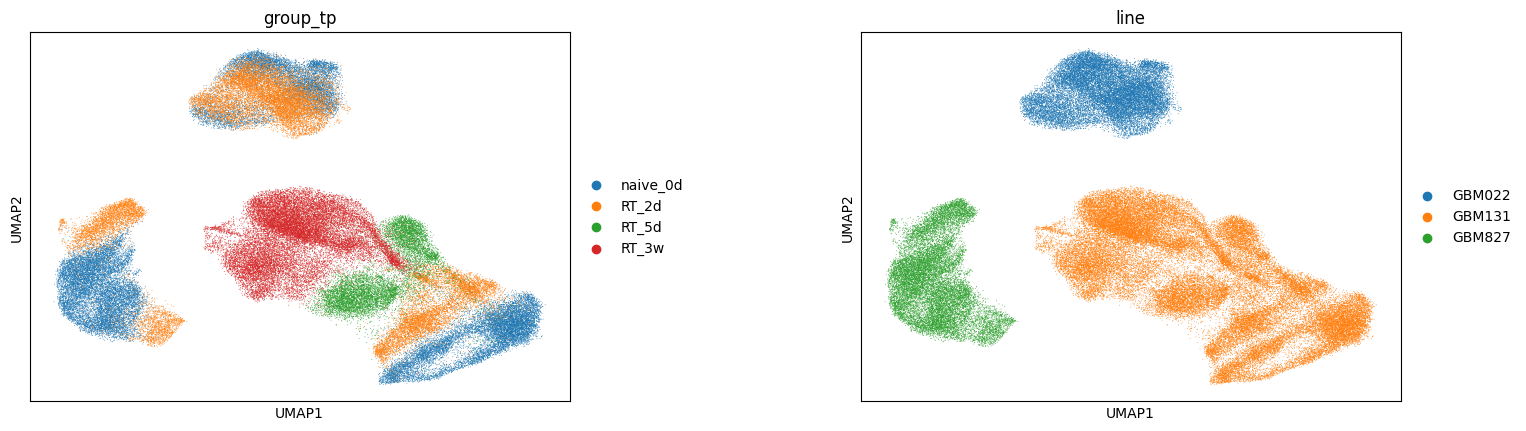

In [ ]:
import scanpy as sc

# 1) 正規化 & log
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# 2) UMAP用にHVGへ絞る（軽量化）
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True)
print("After HVG:", adata.shape)

# 3) PCA → neighbors → UMAP
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

# 4) 表示
sc.pl.umap(adata, color=["group_tp", "line"], wspace=0.4)



n files: 8
GSM4967236 present: ['ARNTL', 'CD38', 'CDH5', 'CDKN1A', 'CDKN2A', 'CLOCK', 'CRY1', 'CRY2', 'KLF4', 'NADSYN1', 'NAMPT', 'NAPRT', 'NMNAT1', 'NMNAT2', 'NMNAT3', 'NMRK1', 'PARP1', 'PER1', 'PER2', 'POU5F1', 'QPRT', 'SIRT1', 'SOX2']
GSM4967237 present: ['ARNTL', 'CD38', 'CDH5', 'CDKN1A', 'CDKN2A', 'CLOCK', 'CRY1', 'CRY2', 'KLF4', 'NADSYN1', 'NAMPT', 'NAPRT', 'NMNAT1', 'NMNAT2', 'NMNAT3', 'NMRK1', 'PARP1', 'PER1', 'PER2', 'POU5F1', 'QPRT', 'SIRT1', 'SOX2']
GSM4967239 present: ['ARNTL', 'CD38', 'CDH5', 'CDKN1A', 'CDKN2A', 'CLOCK', 'CRY1', 'CRY2', 'KLF4', 'NADSYN1', 'NAMPT', 'NAPRT', 'NMNAT1', 'NMNAT2', 'NMNAT3', 'NMRK1', 'PARP1', 'PER1', 'PER2', 'POU5F1', 'QPRT', 'SIRT1', 'SOX2']
GSM4967241 present: ['ARNTL', 'CD38', 'CDH5', 'CDKN1A', 'CDKN2A', 'CLOCK', 'CRY1', 'CRY2', 'KLF4', 'NADSYN1', 'NAMPT', 'NAPRT', 'NMNAT1', 'NMNAT2', 'NMNAT3', 'NMRK1', 'PARP1', 'PER1', 'PER2', 'POU5F1', 'QPRT', 'SIRT1', 'SOX2']
GSM4967242 present: ['ARNTL', 'CD38', 'CDH5', 'CDKN1A', 'CDKN2A', 'CLOCK', 'CRY1'

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


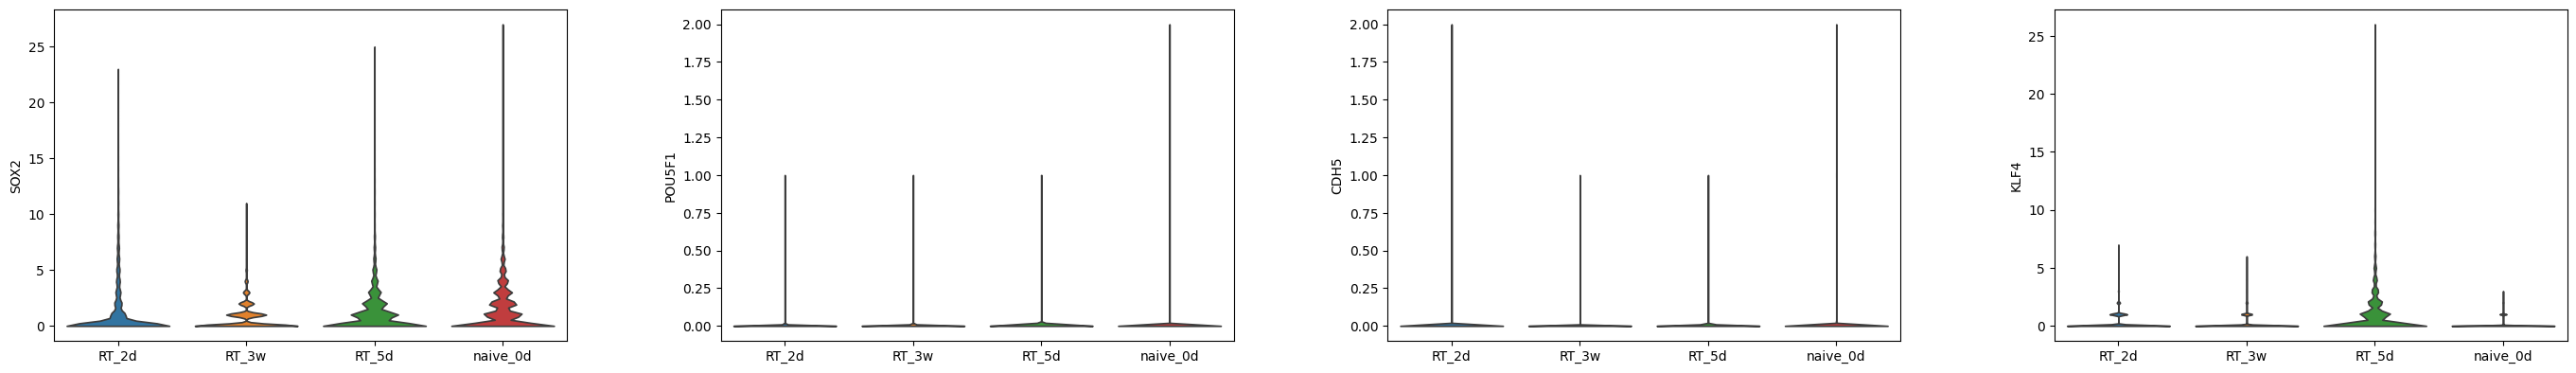

Senescence keys: ['CDKN2A', 'CDKN1A']


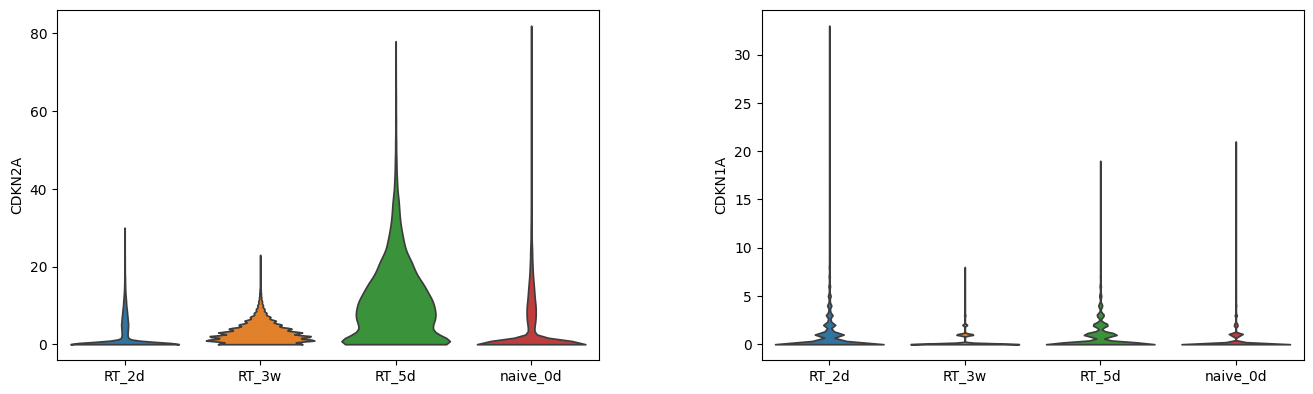

Clock keys: ['ARNTL', 'CLOCK', 'PER1', 'PER2', 'CRY1', 'CRY2']


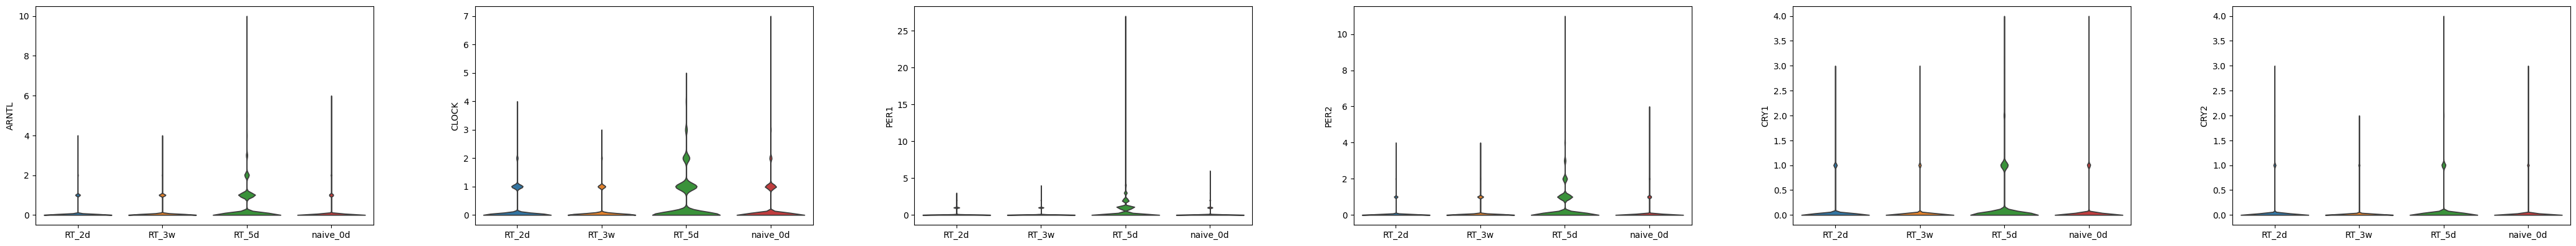

NAD/Met keys: ['NAMPT', 'NAPRT', 'NMNAT1', 'NMNAT2', 'NMNAT3', 'NADSYN1', 'QPRT', 'NMRK1', 'PARP1', 'SIRT1', 'CD38']


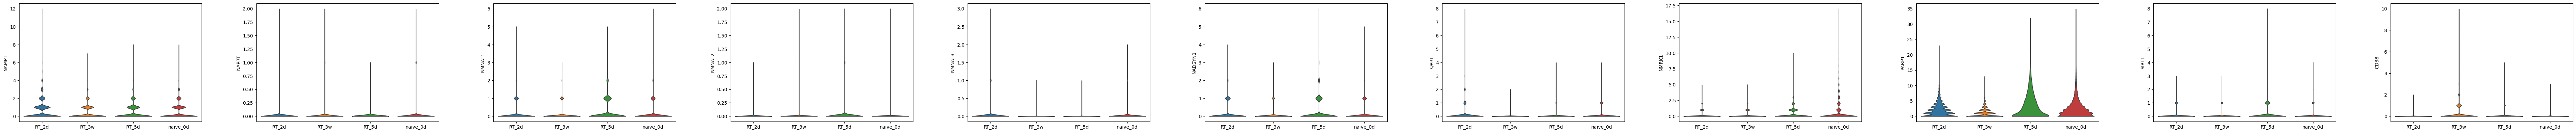

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
from pathlib import Path

# 1) 見たい遺伝子リスト
genes_stem  = ["SOX2","POU5F1","CDH5","KLF4"]
genes_clock = ["ARNTL","CLOCK","PER1","PER2","CRY1","CRY2"]
genes_sen   = ["CDKN2A","CDKN1A"]
genes_met   = ["NAMPT","NAPRT","NMNAT1","NMNAT2","NMNAT3","NADSYN1","QPRT","NMRK1","PARP1","SIRT1","CD38"]
genes_need = sorted(set(genes_stem + genes_clock + genes_sen + genes_met))

# 2) 元のサンプルh5adを読む（HVGで削る前のやつ）
SAMPLE_DIR = Path("GSE162931_work/samples_h5ad")
h5ads = sorted(SAMPLE_DIR.glob("GSM*.h5ad"))
print("n files:", len(h5ads))

def pick_genes(var_names, genes):
    """完全一致 + SOX2-1みたいな重複回避名も拾う"""
    out = []
    for g in genes:
        if g in var_names:
            out.append(g)
        else:
            hits = [x for x in var_names if x.startswith(g + "-")]
            if hits:
                out.append(hits[0])
    return list(dict.fromkeys(out))

ad_small_list = []
for p in h5ads:
    ad = sc.read_h5ad(p)
    gsm = ad.obs["GSM"].iloc[0]
    present = pick_genes(ad.var_names, genes_need)
    print(gsm, "present:", present)

    if len(present) == 0:
        continue

    ad_s = ad[:, present].copy()

    # 軽量化：float32
    if sp.issparse(ad_s.X):
        ad_s.X = ad_s.X.astype(np.float32)
    else:
        ad_s.X = ad_s.X.astype(np.float32, copy=False)

    ad_small_list.append(ad_s)

# 小さいので outer でOK（遺伝子欠損しても列が残る）
adata_v = sc.concat(ad_small_list, join="outer")
print("adata_v:", adata_v.shape)

def plot_violin(glist, title):
    keys = pick_genes(adata_v.var_names, glist)
    print(title, "keys:", keys)
    if keys:
        sc.pl.violin(adata_v, keys=keys, groupby="group_tp",
                     stripplot=False, jitter=False, multi_panel=True, rotation=0)

plot_violin(genes_stem,  "Stem")
plot_violin(genes_sen,   "Senescence")
plot_violin(genes_clock, "Clock")
plot_violin(genes_met,   "NAD/Met")


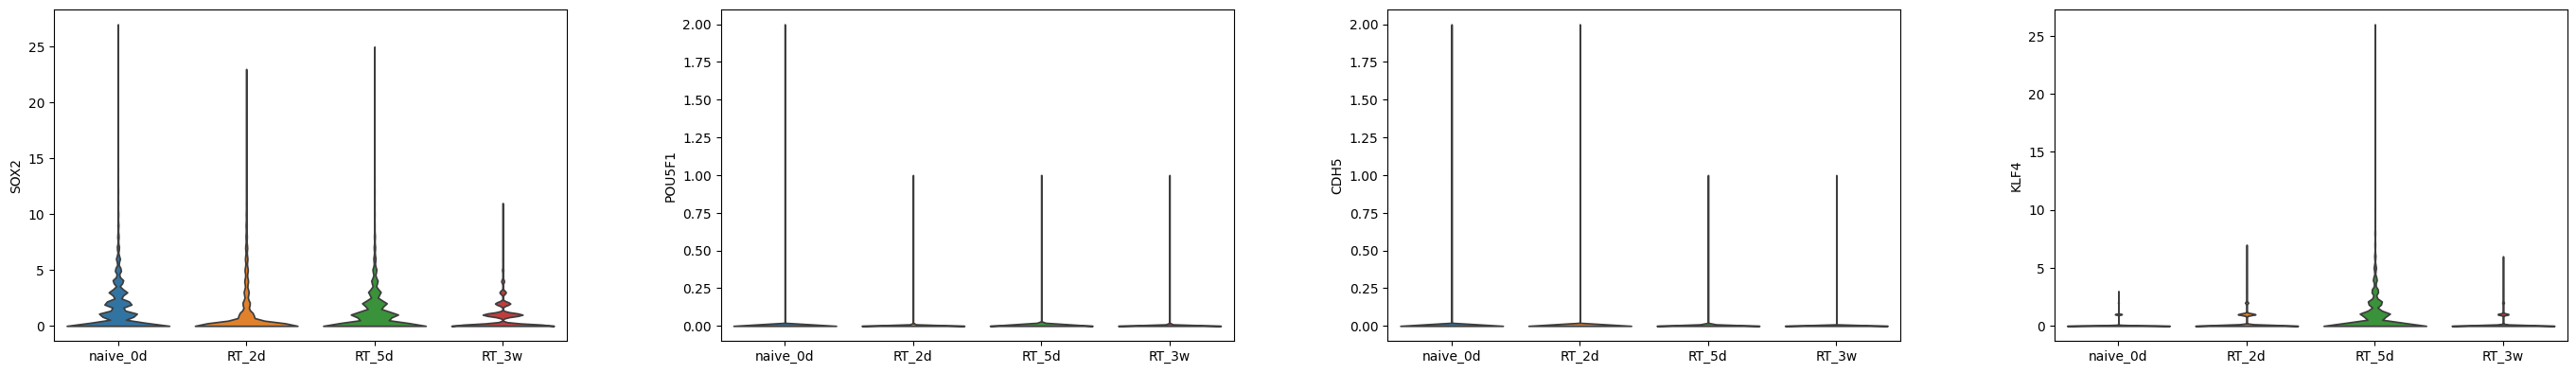

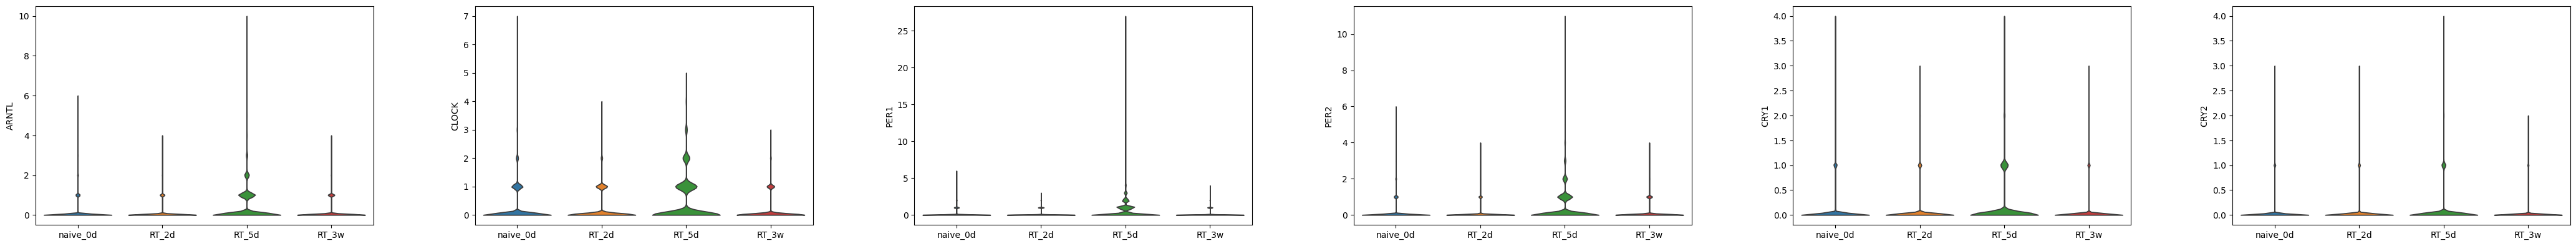

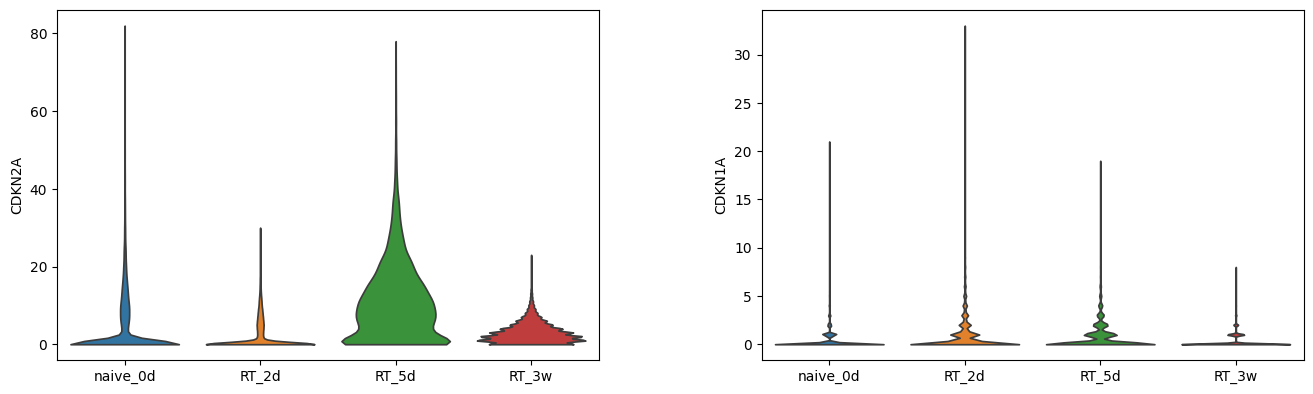

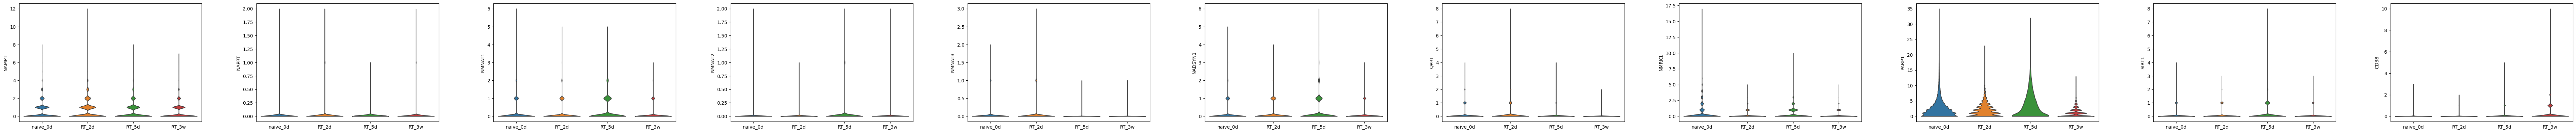

In [ ]:
import pandas as pd
import scanpy as sc

# タイムコース順を強制
order = ["naive_0d", "RT_2d", "RT_5d", "RT_3w"]
adata_v.obs["group_tp"] = pd.Categorical(adata_v.obs["group_tp"], categories=order, ordered=True)

# 1セット＝1枚の図（multi_panel=Trueで1つのFigureに並ぶ）
sc.pl.violin(adata_v, keys=genes_stem,  groupby="group_tp",
             stripplot=False, jitter=False, multi_panel=True, rotation=0)

sc.pl.violin(adata_v, keys=genes_clock, groupby="group_tp",
             stripplot=False, jitter=False, multi_panel=True, rotation=0)

sc.pl.violin(adata_v, keys=genes_sen,   groupby="group_tp",
             stripplot=False, jitter=False, multi_panel=True, rotation=0)

sc.pl.violin(adata_v, keys=genes_met,   groupby="group_tp",
             stripplot=False, jitter=False, multi_panel=True, rotation=0)


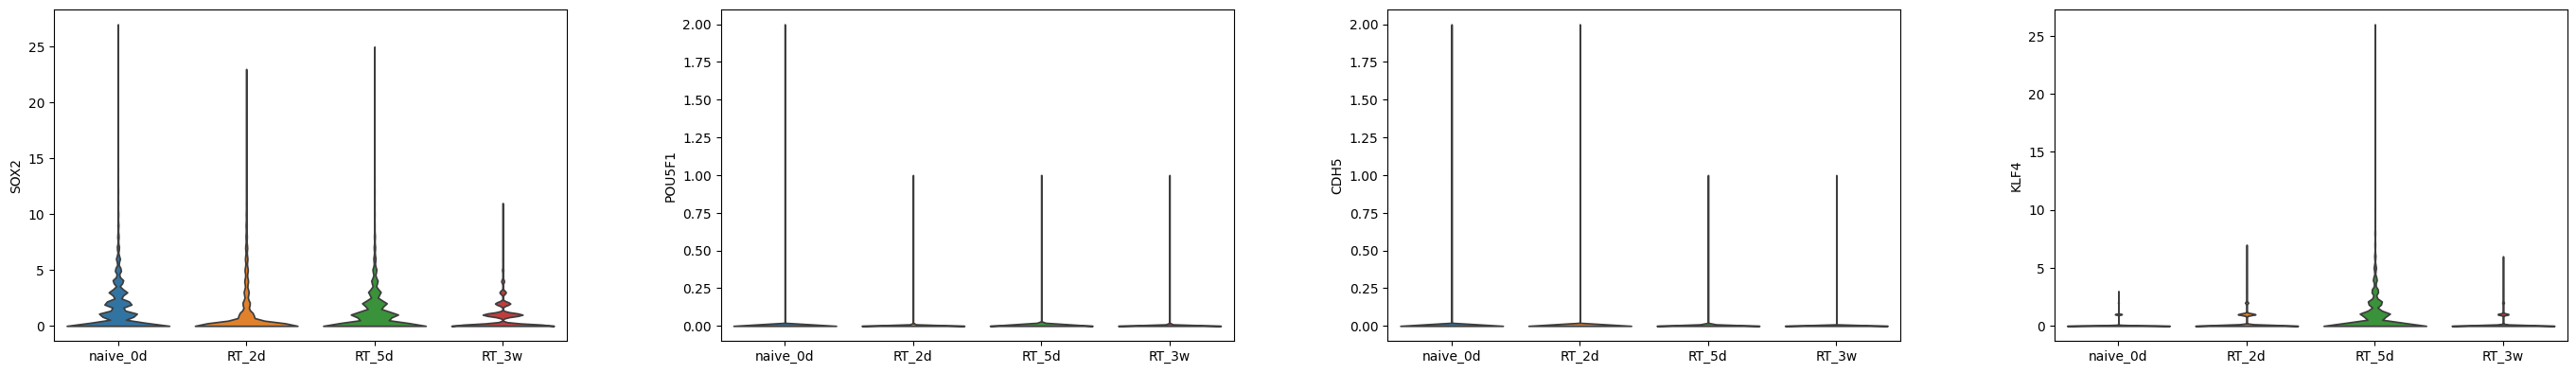

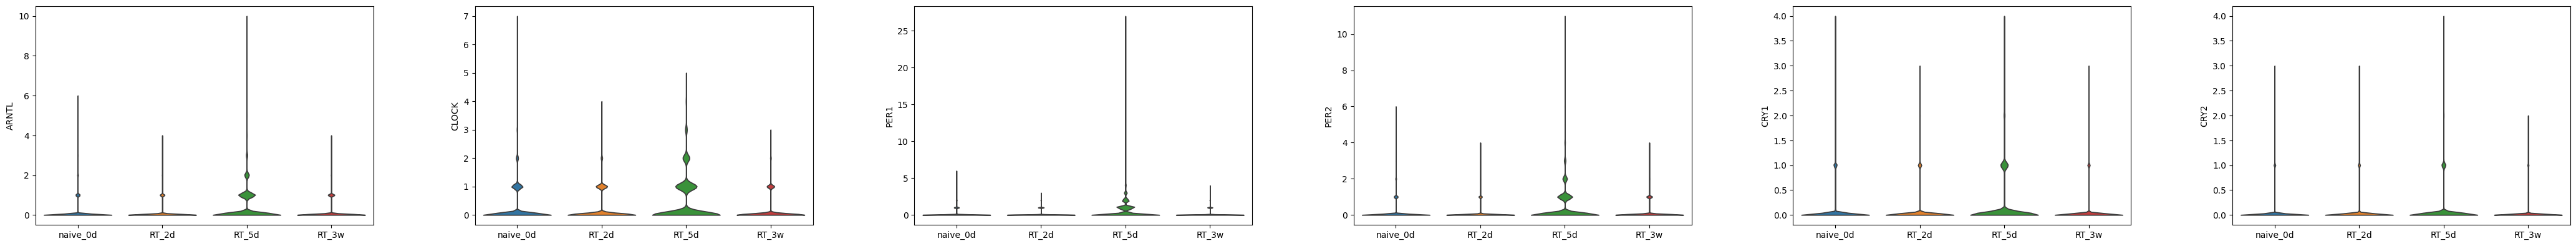

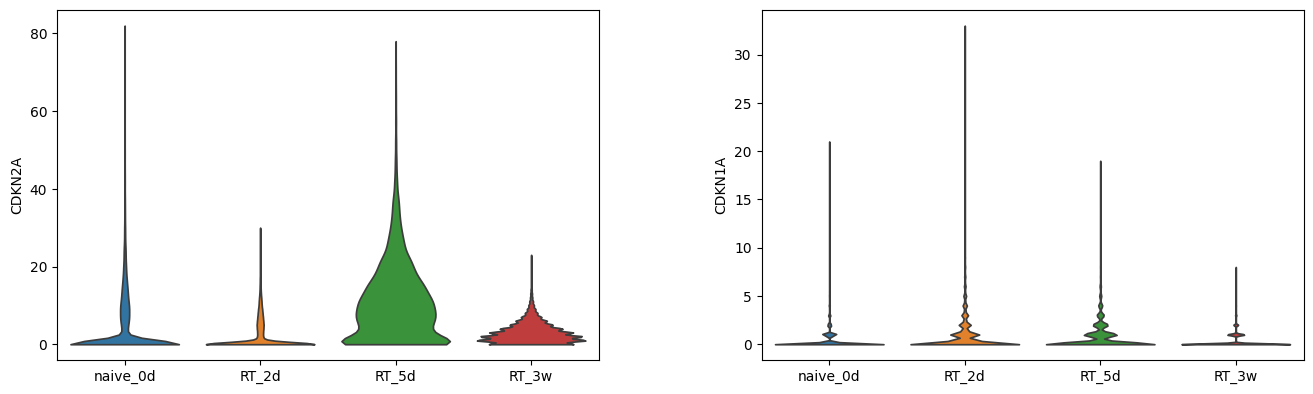

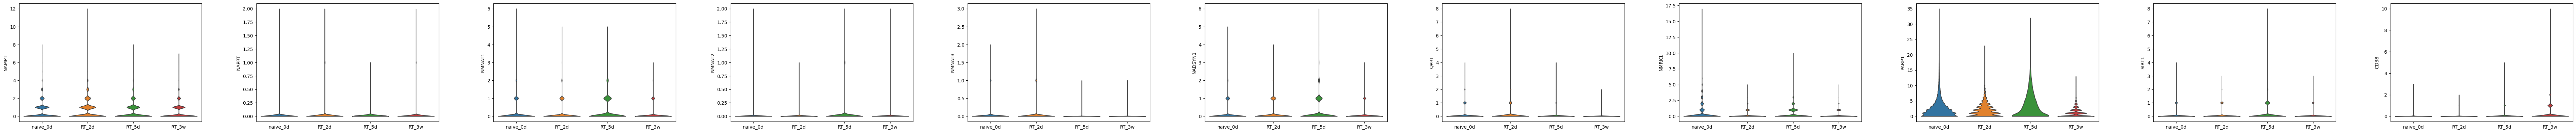

In [ ]:
import pandas as pd
import scanpy as sc

# --- タイムコース順を明示（念のため） ---
order = ["naive_0d", "RT_2d", "RT_5d", "RT_3w"]
adata_v.obs["group_tp"] = pd.Categorical(
    adata_v.obs["group_tp"],
    categories=order,
    ordered=True
)

# --- Stem genes：1枚のFigure ---
sc.pl.violin(
    adata_v,
    keys=genes_stem,
    groupby="group_tp",
    stripplot=False,
    jitter=False,
    multi_panel=True,
    rotation=0
)

# --- Clock genes：1枚のFigure ---
sc.pl.violin(
    adata_v,
    keys=genes_clock,
    groupby="group_tp",
    stripplot=False,
    jitter=False,
    multi_panel=True,
    rotation=0
)

# --- Senescence genes：1枚のFigure ---
sc.pl.violin(
    adata_v,
    keys=genes_sen,
    groupby="group_tp",
    stripplot=False,
    jitter=False,
    multi_panel=True,
    rotation=0
)

# --- NAD / Metabolism genes：1枚のFigure ---
sc.pl.violin(
    adata_v,
    keys=genes_met,
    groupby="group_tp",
    stripplot=False,
    jitter=False,
    multi_panel=True,
    rotation=0
)


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


common cells: 86295 / 86295
[OK] SOX2_expr <- SOX2
[OK] POU5F1_expr <- POU5F1
[OK] CDH5_expr <- CDH5
[OK] KLF4_expr <- KLF4


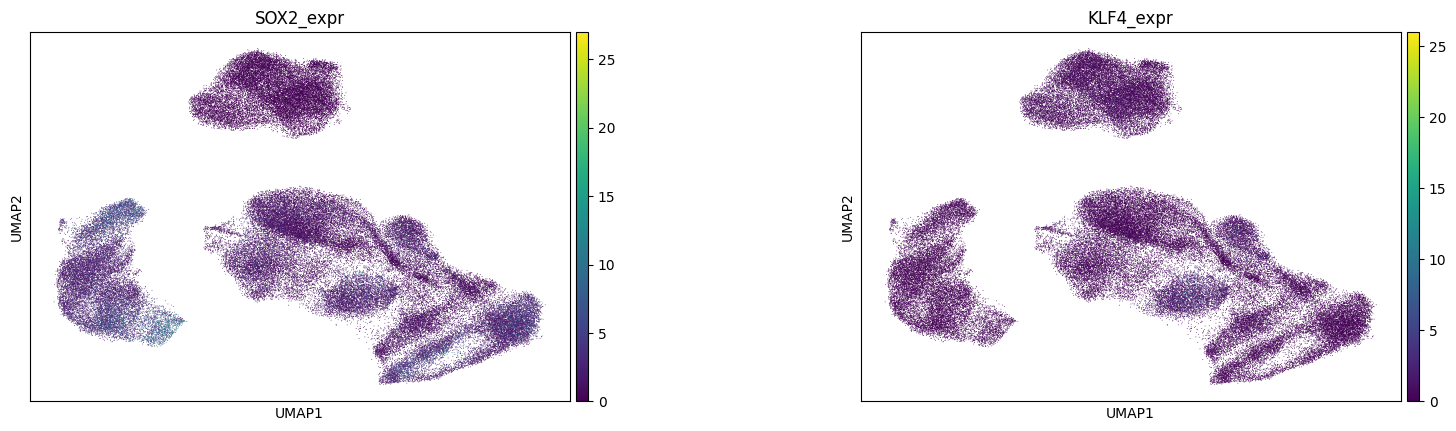

In [ ]:
import numpy as np
import scipy.sparse as sp
import scanpy as sc

# ---- 1) cell_idで揃える（同じ）----
adata.obs["cell_id"]   = adata.obs["GSM"].astype(str) + "_" + adata.obs_names.astype(str)
adata_v.obs["cell_id"] = adata_v.obs["GSM"].astype(str) + "_" + adata_v.obs_names.astype(str)

adata_by_id = adata.copy()
adata_by_id.obs_names = adata_by_id.obs["cell_id"].astype(str)

adata_v_by_id = adata_v.copy()
adata_v_by_id.obs_names = adata_v_by_id.obs["cell_id"].astype(str)

common = adata_by_id.obs_names.intersection(adata_v_by_id.obs_names)
adata_by_id = adata_by_id[common].copy()
adata_v_by_id = adata_v_by_id[common].copy()
print("common cells:", len(common), "/", adata.n_obs)

# ---- 2) 遺伝子名を拾う（SOX2-1対応）----
def pick_one_gene(var_names, g):
    if g in var_names:
        return g
    hits = [x for x in var_names if x.startswith(g + "-")]
    return hits[0] if hits else None

# ---- 3) obsに入れる列名は必ず "_expr" を付ける（衝突回避）----
def transfer_gene_to_obs_expr(gene_symbol):
    gname = pick_one_gene(adata_v_by_id.var_names, gene_symbol)
    if gname is None:
        print(f"[MISS] {gene_symbol} not found in adata_v")
        return None

    x = adata_v_by_id[:, gname].X
    x = x.toarray().ravel() if sp.issparse(x) else np.asarray(x).ravel()

    col = gene_symbol + "_expr"
    adata_by_id.obs[col] = x
    print(f"[OK] {col} <- {gname}")
    return col

# ---- 4) 例：Stem遺伝子をUMAPで描く（2つずつ）----
cols = []
for g in genes_stem:
    c = transfer_gene_to_obs_expr(g)
    if c: cols.append(c)

# SOX2とKLF4を表示
sc.pl.umap(adata_by_id, color=["SOX2_expr", "KLF4_expr"], wspace=0.4)

# ついでに残りも見たいなら：
# sc.pl.umap(adata_by_id, color=["POU5F1_expr", "CDH5_expr]()



/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



==== GBM131 cells= 53188 ====


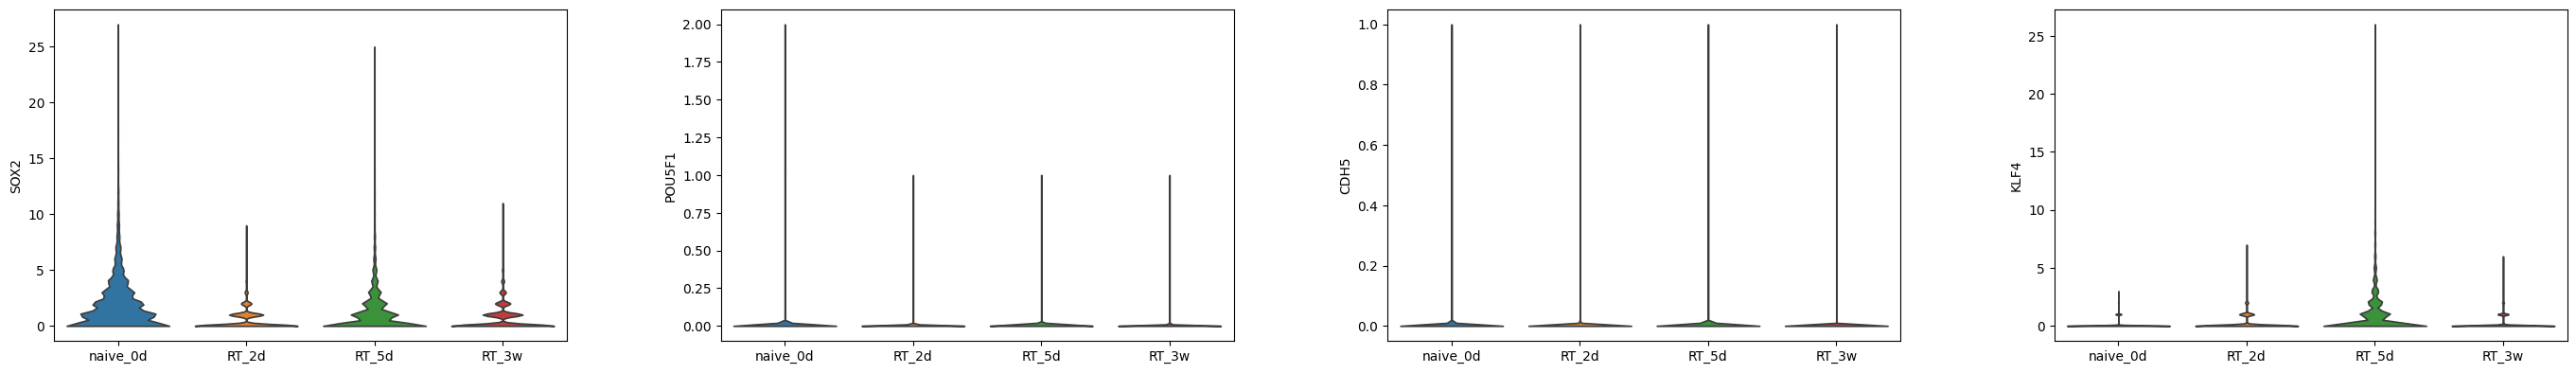

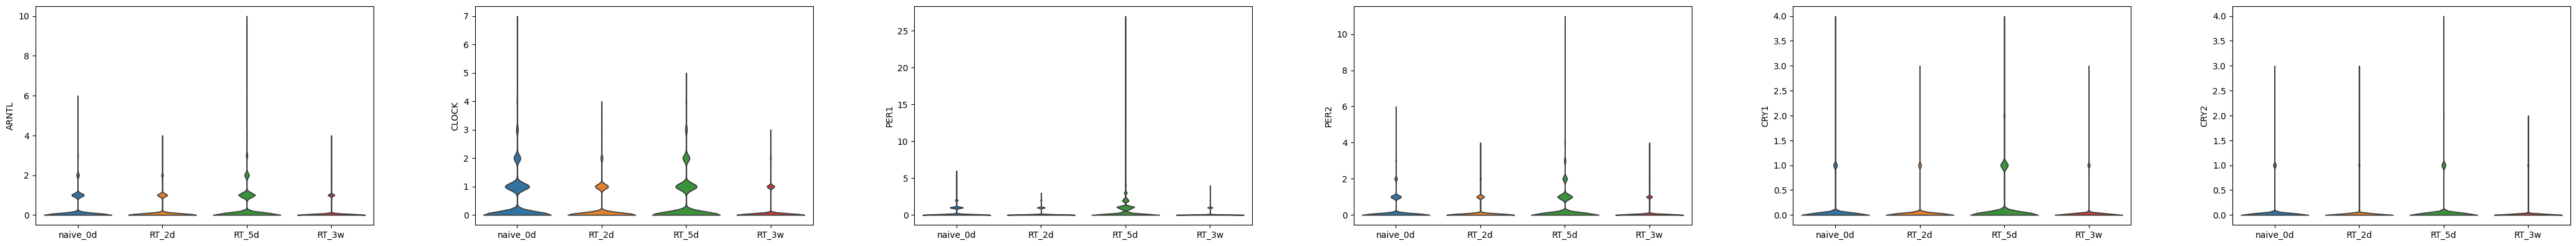

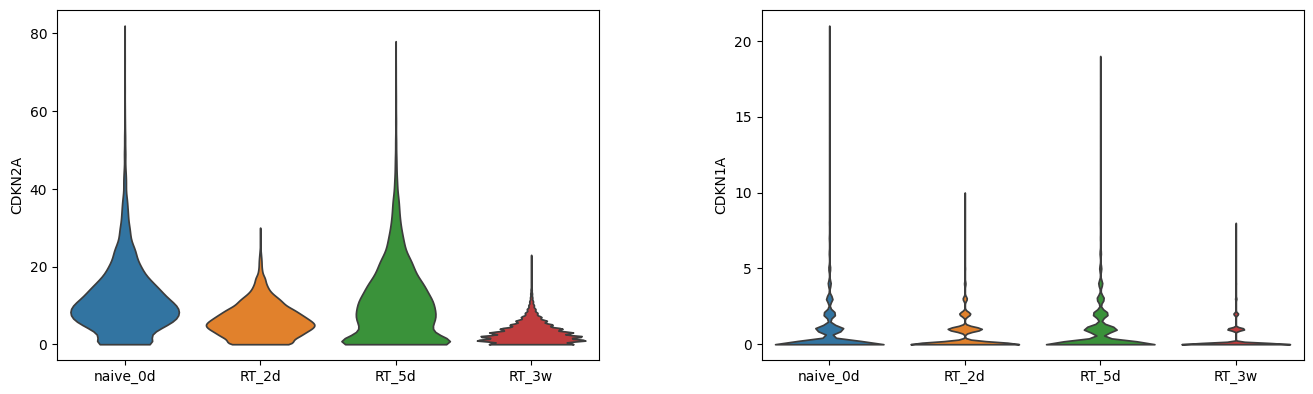

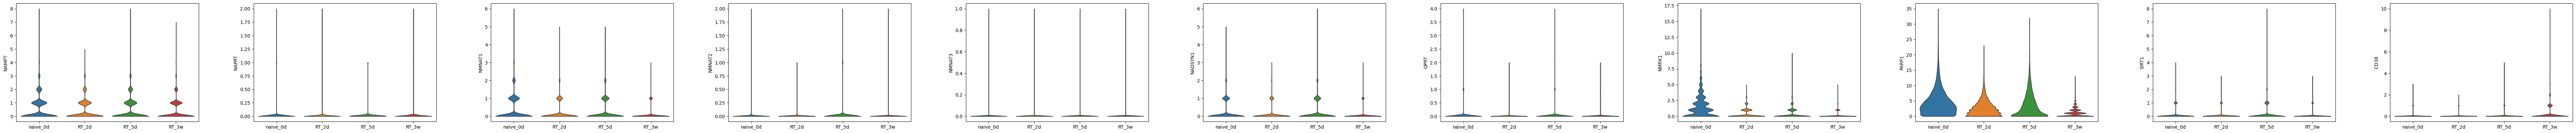

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



==== GBM022 cells= 20290 ====


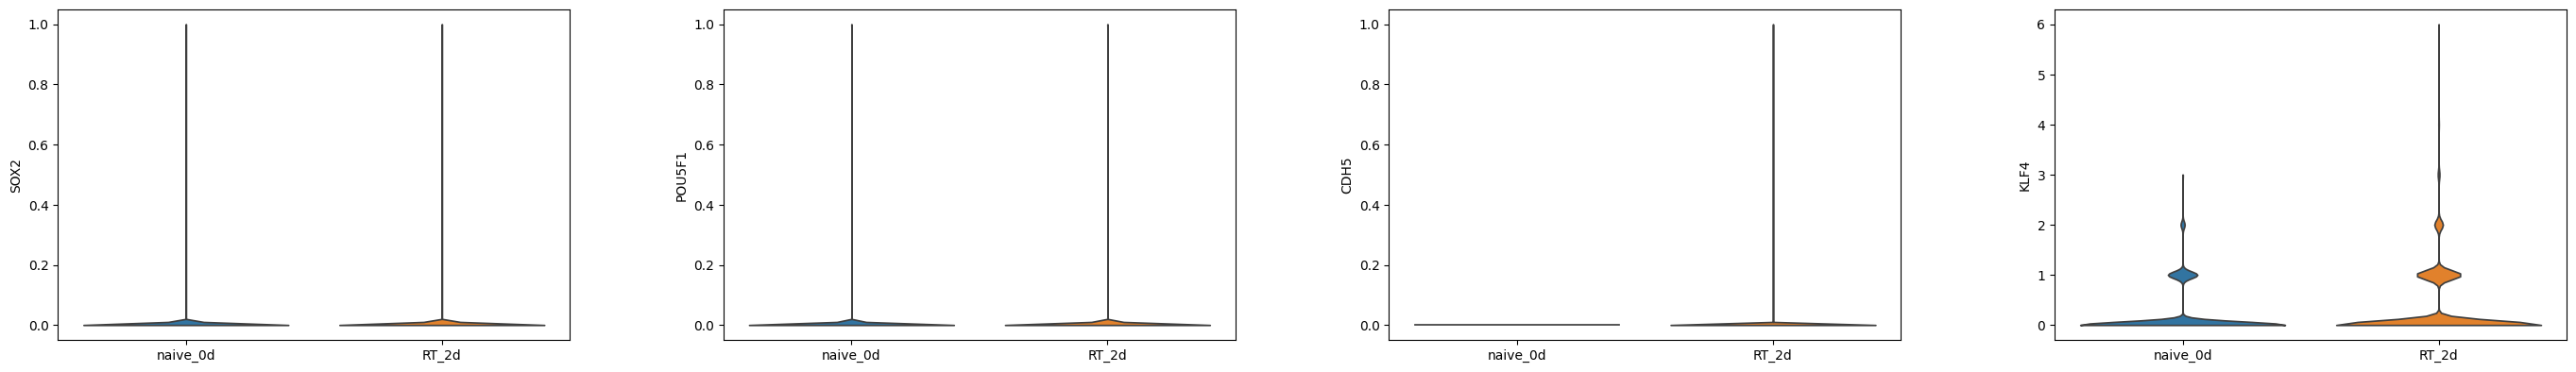

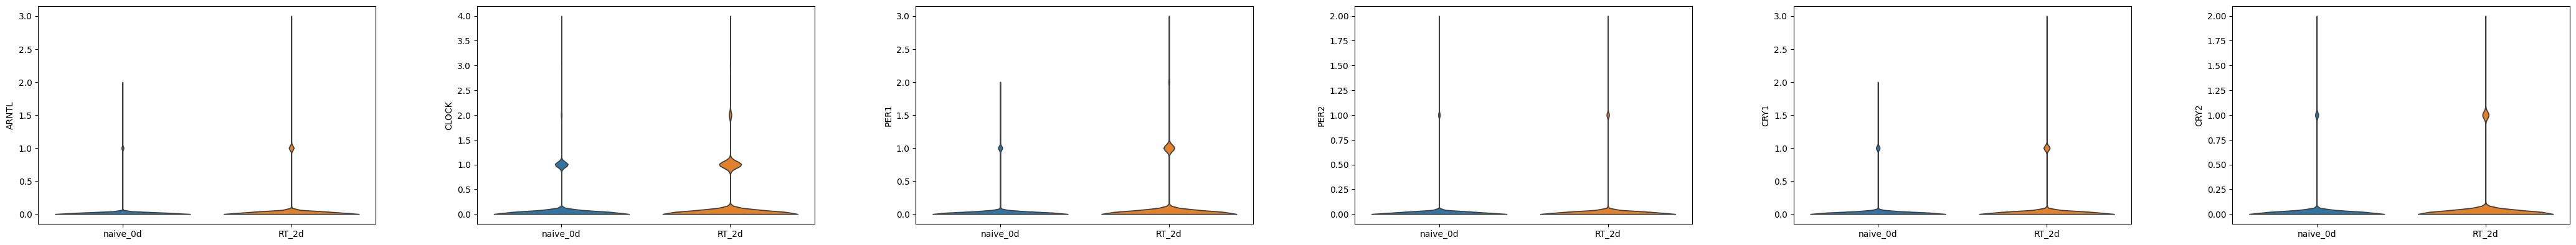

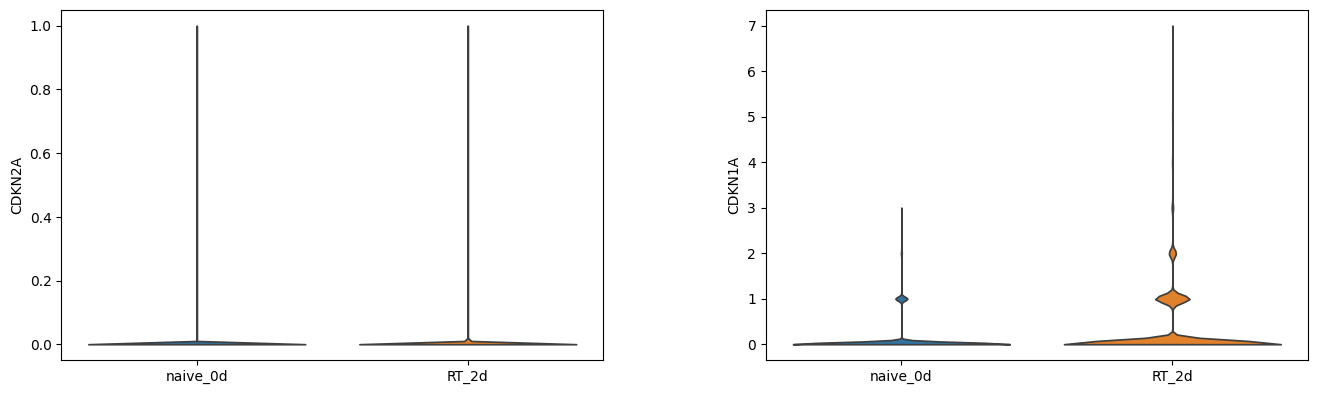

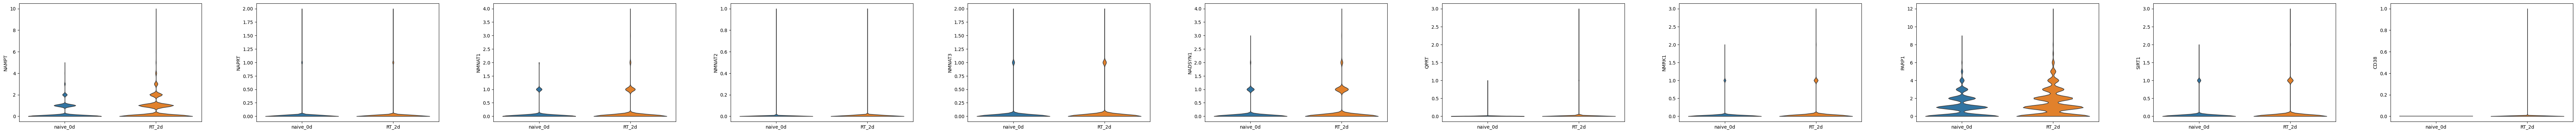

/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1806: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")



==== GBM827 cells= 17344 ====


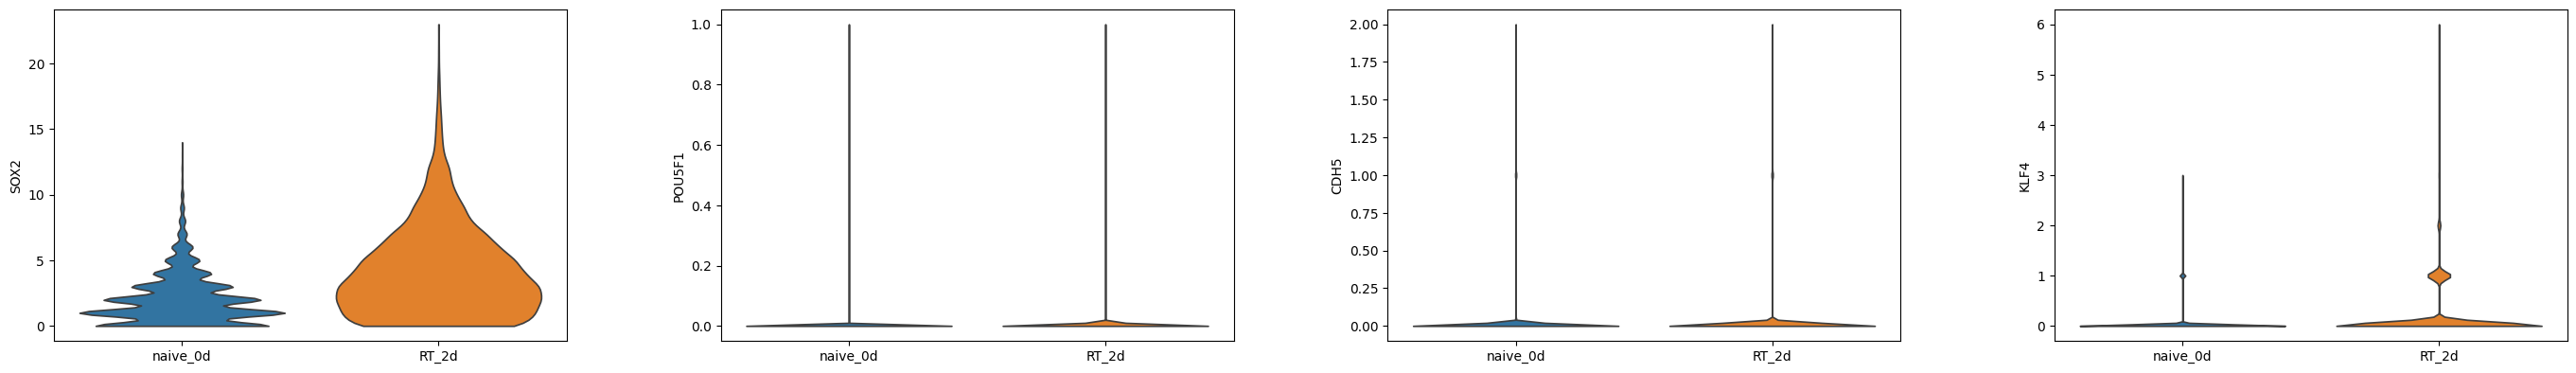

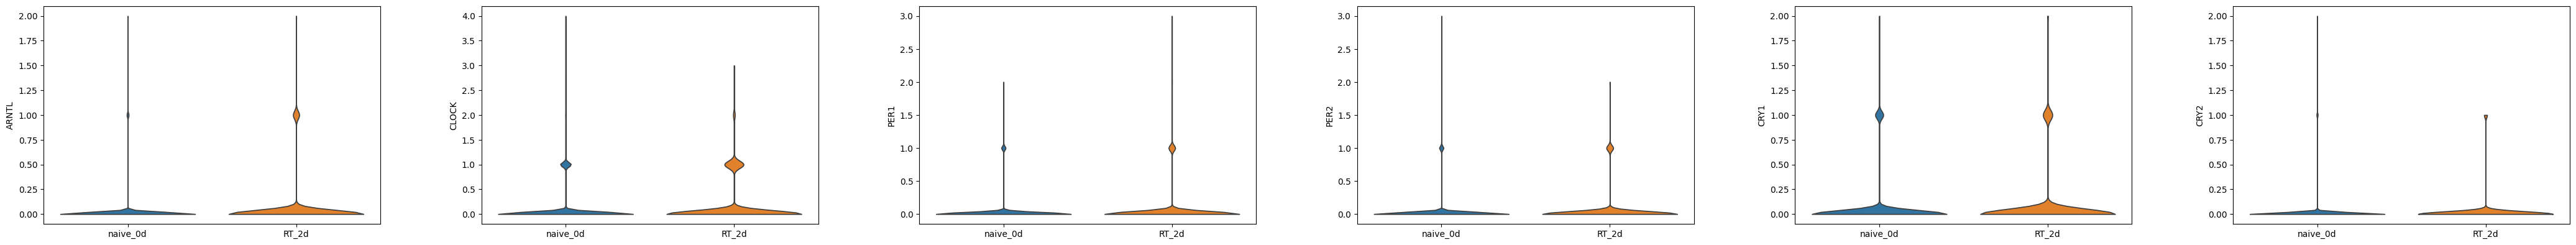

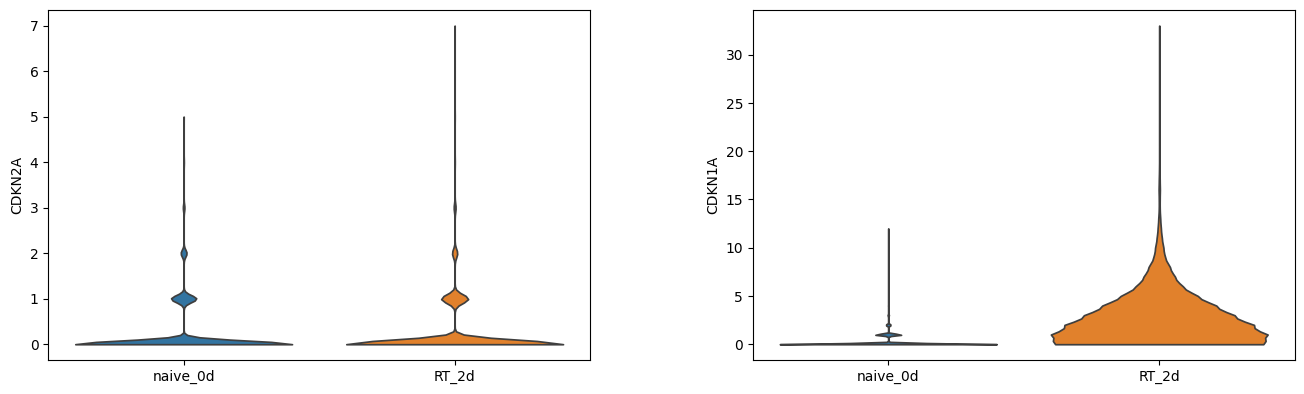

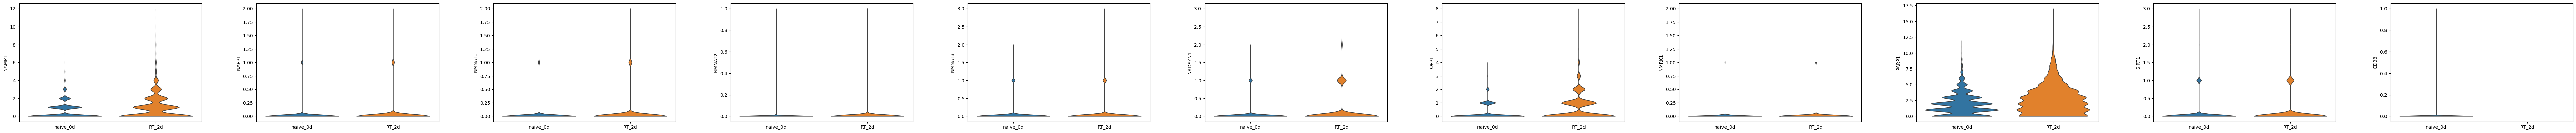

In [ ]:
import scanpy as sc
import pandas as pd

# 時間順
order = ["naive_0d", "RT_2d", "RT_5d", "RT_3w"]
adata_v.obs["group_tp"] = pd.Categorical(adata_v.obs["group_tp"], categories=order, ordered=True)

for ln in ["GBM131","GBM022","GBM827"]:
    sub = adata_v[adata_v.obs["line"] == ln].copy()
    print("\n====", ln, "cells=", sub.n_obs, "====")
    sc.pl.violin(sub, keys=genes_stem,  groupby="group_tp", stripplot=False, jitter=False, multi_panel=True, rotation=0)
    sc.pl.violin(sub, keys=genes_clock, groupby="group_tp", stripplot=False, jitter=False, multi_panel=True, rotation=0)
    sc.pl.violin(sub, keys=genes_sen,   groupby="group_tp", stripplot=False, jitter=False, multi_panel=True, rotation=0)
    sc.pl.violin(sub, keys=genes_met,   groupby="group_tp", stripplot=False, jitter=False, multi_panel=True, rotation=0)
